# AIRBNB PRICE PREDICTION - MODEL TRAINING PIPELINE
## Feature Engineering, Selection, Dimension Reduction & Model Training

**Models:**
1. Linear Regression (with regularization)
2. Random Forest
3. XGBoost
4. Bagging Regressor
5. Voting Regressor

**Pipeline:**
- Advanced Feature Engineering
- Feature Selection (Multiple Methods)
- Dimension Reduction (PCA)
- Hyperparameter Tuning
- Model Evaluation & Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import subprocess

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create Emin_plots directory
os.makedirs('Emin_plots', exist_ok=True)
os.makedirs('Emin_models', exist_ok=True)

print("="*80)
print("AIRBNB PRICE PREDICTION - MODEL TRAINING")
print("="*80)

AIRBNB PRICE PREDICTION - MODEL TRAINING


In [2]:
#============================================================================
# STEP 1: LOAD DATA
#============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

X_train = np.load('processed_data/X_train_standard.npy')
X_val = np.load('processed_data/X_val_standard.npy')
X_test = np.load('processed_data/X_test_standard.npy')

y_train = np.load('processed_data/y_train.npy')
y_val = np.load('processed_data/y_val.npy')
y_test = np.load('processed_data/y_test.npy')

feature_names_df = pd.read_csv('processed_data/feature_names.csv')
feature_names = feature_names_df['feature'].tolist()

print(f"\n✓ Data loaded successfully!")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"  Features: {len(feature_names)}")



STEP 1: LOADING DATA

✓ Data loaded successfully!
  Train: (12016, 102)
  Val:   (4006, 102)
  Test:  (4006, 102)
  Features: 102



📊 Plotting target distribution...


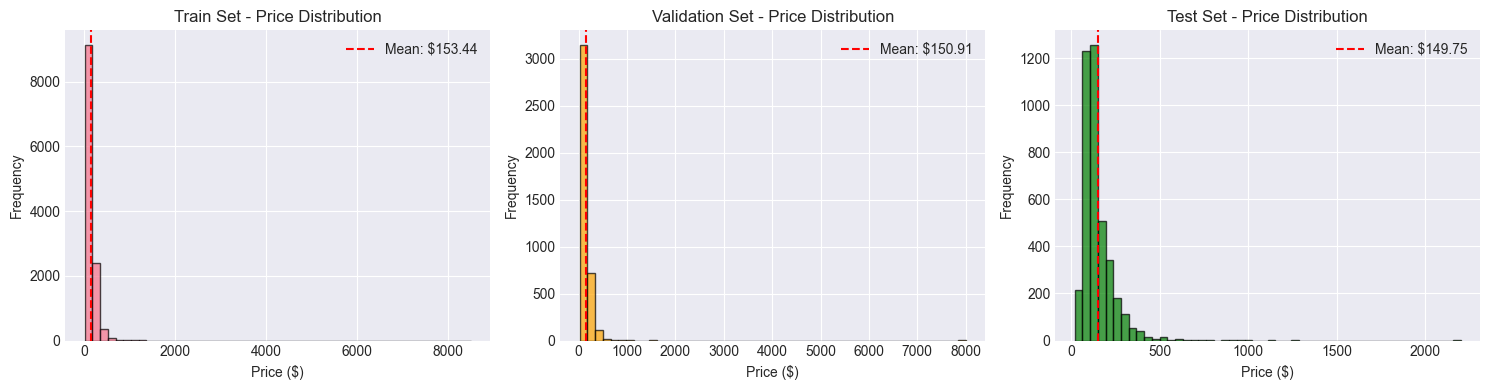

✓ Saved: Emin_plots/01_target_distribution.png


In [3]:
# VISUALIZE TARGET DISTRIBUTION
print("\n📊 Plotting target distribution...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Train Set - Price Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(y_train.mean(), color='r', linestyle='--', label=f'Mean: ${y_train.mean():.2f}')
axes[0].legend()

axes[1].hist(y_val, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Validation Set - Price Distribution')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(y_val.mean(), color='r', linestyle='--', label=f'Mean: ${y_val.mean():.2f}')
axes[1].legend()

axes[2].hist(y_test, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[2].set_title('Test Set - Price Distribution')
axes[2].set_xlabel('Price ($)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(y_test.mean(), color='r', linestyle='--', label=f'Mean: ${y_test.mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('Emin_plots/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: Emin_plots/01_target_distribution.png")


In [4]:
#============================================================================
# STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING
#============================================================================
print("\n" + "="*80)
print("STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING")
print("="*80)

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ============================================================================
# REMOVE DATA LEAKAGE FEATURES
# ============================================================================
print("\n🚨 Removing features with data leakage...")

leakage_features = [
    'avg_calendar_price',      # Directly leaks price information
    'min_calendar_price',      # Directly leaks price information
    'max_calendar_price',      # Directly leaks price information
]

dropped_leakage = [f for f in leakage_features if f in X_train_df.columns]
if dropped_leakage:
    X_train_df = X_train_df.drop(columns=dropped_leakage)
    X_val_df = X_val_df.drop(columns=dropped_leakage)
    X_test_df = X_test_df.drop(columns=dropped_leakage)
    for feat in dropped_leakage:
        print(f"  ✗ Dropped: {feat} (data leakage)")

# ============================================================================
# REMOVE UNNECESSARY HOST FEATURES
# ============================================================================
print("\n🧹 Removing unnecessary host features...")

unnecessary_host_features = [
    'host_name_target_encoded',           # Host name shouldn't affect price
    'host_location_target_encoded',       # Redundant with property location
    'host_neighbourhood_target_encoded',  # Redundant with property neighbourhood
    'host_has_profile_pic_True',          # Minimal impact on price
]

# Also remove all host_response_time features (low importance)
host_response_time_cols = [c for c in X_train_df.columns if 'host_response_time_' in c]
unnecessary_host_features.extend(host_response_time_cols)

dropped_host = [f for f in unnecessary_host_features if f in X_train_df.columns]
if dropped_host:
    X_train_df = X_train_df.drop(columns=dropped_host)
    X_val_df = X_val_df.drop(columns=dropped_host)
    X_test_df = X_test_df.drop(columns=dropped_host)
    for feat in dropped_host:
        print(f"  ✗ Dropped: {feat} (unnecessary)")

print(f"\n✓ Removed {len(dropped_leakage)} leakage features")
print(f"✓ Removed {len(dropped_host)} unnecessary host features")
print(f"✓ Remaining features: {X_train_df.shape[1]}")

# ============================================================================
# FEATURE ENGINEERING (WITHOUT LEAKAGE)
# ============================================================================
print("\n" + "="*80)
print("CREATING NEW FEATURES (NO LEAKAGE)")
print("="*80)

new_features = []

# 1. Reviews per day (engagement metric)
if 'number_of_reviews' in X_train_df.columns and 'host_tenure_days' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['reviews_per_day'] = df['number_of_reviews'] / (df['host_tenure_days'] + 1)
    new_features.append('reviews_per_day')
    print("✓ Created: reviews_per_day")

# 2. Availability ratio (booking flexibility)
if 'availability_365' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['availability_ratio'] = df['availability_365'] / 365.0
    new_features.append('availability_ratio')
    print("✓ Created: availability_ratio")

# 3. Review score average (overall quality)
review_cols = [c for c in X_train_df.columns if 'review_scores_' in c]
if len(review_cols) > 0:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['avg_review_score'] = df[review_cols].mean(axis=1)
    new_features.append('avg_review_score')
    print("✓ Created: avg_review_score")

# 4. Beds per bedroom (space efficiency)
if 'beds' in X_train_df.columns and 'bedrooms' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['beds_per_bedroom'] = df['beds'] / (df['bedrooms'] + 1)
    new_features.append('beds_per_bedroom')
    print("✓ Created: beds_per_bedroom")

# 5. Host experience (host quality metric)
if 'calculated_host_listings_count' in X_train_df.columns and 'host_tenure_years' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['host_experience'] = df['calculated_host_listings_count'] * df['host_tenure_years']
    new_features.append('host_experience')
    print("✓ Created: host_experience")

# 6. Space per person (capacity efficiency)
if 'accommodates' in X_train_df.columns and 'bedrooms' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['space_per_person'] = df['bedrooms'] / (df['accommodates'] + 1)
    new_features.append('space_per_person')
    print("✓ Created: space_per_person")

# 7. Total amenities score (comfort level)
if 'amenities_count' in X_train_df.columns:
    amenity_cols = ['has_wifi', 'has_kitchen', 'has_tv', 'has_parking', 'has_ac', 'has_heating']
    existing_amenity_cols = [c for c in amenity_cols if c in X_train_df.columns]
    if existing_amenity_cols:
        for df in [X_train_df, X_val_df, X_test_df]:
            df['premium_amenities_score'] = df[existing_amenity_cols].sum(axis=1)
        new_features.append('premium_amenities_score')
        print("✓ Created: premium_amenities_score")

X_train_eng = X_train_df.values
X_val_eng = X_val_df.values
X_test_eng = X_test_df.values
feature_names_eng = X_train_df.columns.tolist()

print(f"\n✓ Feature engineering complete!")
print(f"  Original features: {len(feature_names)}")
print(f"  Dropped (leakage + unnecessary): {len(dropped_leakage) + len(dropped_host)}")
print(f"  New features added: {len(new_features)}")
print(f"  Total features: {len(feature_names_eng)}")


STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING

🚨 Removing features with data leakage...
  ✗ Dropped: avg_calendar_price (data leakage)
  ✗ Dropped: min_calendar_price (data leakage)
  ✗ Dropped: max_calendar_price (data leakage)

🧹 Removing unnecessary host features...
  ✗ Dropped: host_name_target_encoded (unnecessary)
  ✗ Dropped: host_location_target_encoded (unnecessary)
  ✗ Dropped: host_neighbourhood_target_encoded (unnecessary)
  ✗ Dropped: host_has_profile_pic_True (unnecessary)
  ✗ Dropped: host_response_time_a few days or more (unnecessary)
  ✗ Dropped: host_response_time_within a day (unnecessary)
  ✗ Dropped: host_response_time_within a few hours (unnecessary)
  ✗ Dropped: host_response_time_within an hour (unnecessary)

✓ Removed 3 leakage features
✓ Removed 8 unnecessary host features
✓ Remaining features: 91

CREATING NEW FEATURES (NO LEAKAGE)
✓ Created: reviews_per_day
✓ Created: availability_ratio
✓ Created: avg_review_score
✓ Created: beds_per_bedroom
✓ Created:

In [5]:
#============================================================================
# STEP 3: FEATURE SELECTION
#============================================================================
print("\n" + "="*80)
print("STEP 3: FEATURE SELECTION")
print("="*80)

# F-statistic
print("  Computing F-statistic...")
f_selector = SelectKBest(f_regression, k='all')
f_selector.fit(X_train_eng, y_train)
f_scores = f_selector.scores_

# Mutual Information
print("  Computing Mutual Information...")
mi_scores = mutual_info_regression(X_train_eng, y_train, random_state=42)

# Random Forest Importance
print("  Computing Random Forest Importance...")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_temp.fit(X_train_eng, y_train)
rf_importance = rf_temp.feature_importances_

# Combine scores
feature_scores_df = pd.DataFrame({
    'feature': feature_names_eng,
    'f_score': f_scores,
    'mi_score': mi_scores,
    'rf_importance': rf_importance
})

# Normalize and combine
for col in ['f_score', 'mi_score', 'rf_importance']:
    feature_scores_df[f'{col}_norm'] = (
        (feature_scores_df[col] - feature_scores_df[col].min()) /
        (feature_scores_df[col].max() - feature_scores_df[col].min())
    )

feature_scores_df['combined_score'] = (
    feature_scores_df['f_score_norm'] +
    feature_scores_df['mi_score_norm'] +
    feature_scores_df['rf_importance_norm']
) / 3

feature_scores_df = feature_scores_df.sort_values('combined_score', ascending=False)
feature_scores_df.to_csv('feature_importance_rankings.csv', index=False)



STEP 3: FEATURE SELECTION
  Computing F-statistic...
  Computing Mutual Information...
  Computing Random Forest Importance...



📊 Plotting feature importance...


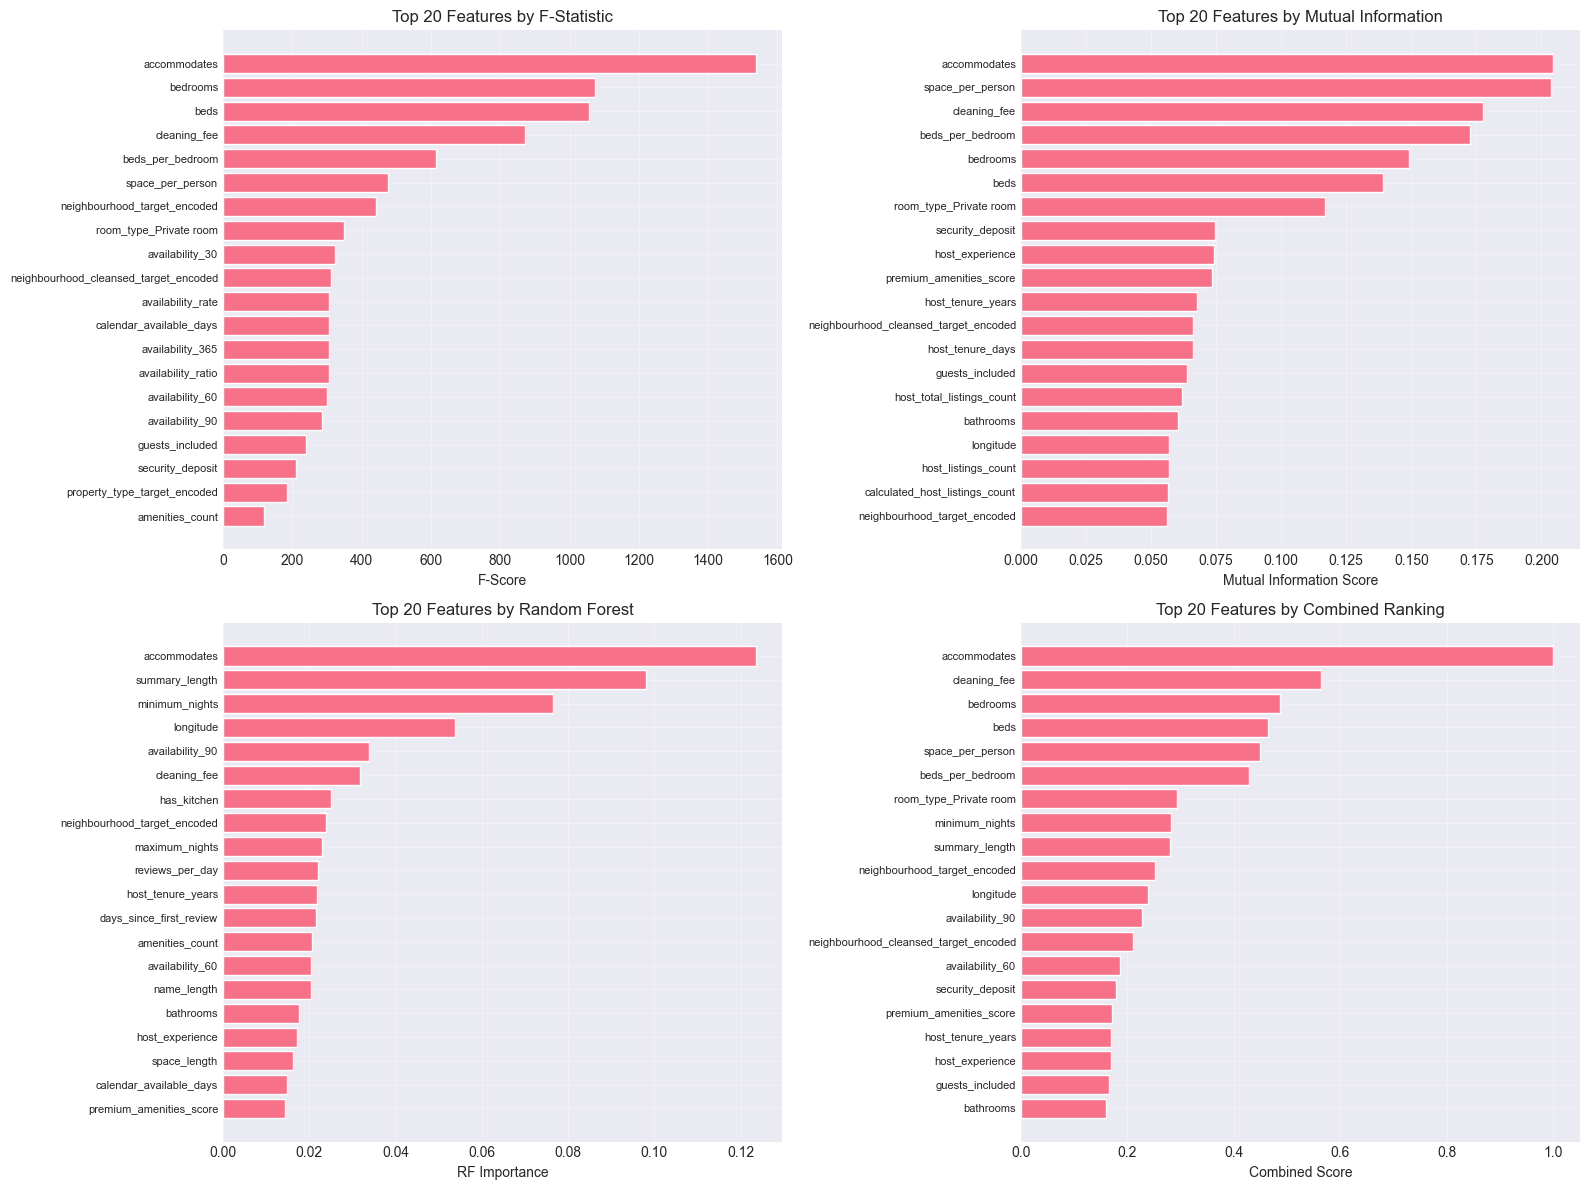

✓ Saved: Emin_plots/02_feature_importance.png


In [6]:
# VISUALIZE FEATURE IMPORTANCE
print("\n📊 Plotting feature importance...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F-Score
top_20_f = feature_scores_df.nlargest(20, 'f_score')
axes[0, 0].barh(range(len(top_20_f)), top_20_f['f_score'])
axes[0, 0].set_yticks(range(len(top_20_f)))
axes[0, 0].set_yticklabels(top_20_f['feature'], fontsize=8)
axes[0, 0].set_xlabel('F-Score')
axes[0, 0].set_title('Top 20 Features by F-Statistic')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Mutual Information
top_20_mi = feature_scores_df.nlargest(20, 'mi_score')
axes[0, 1].barh(range(len(top_20_mi)), top_20_mi['mi_score'])
axes[0, 1].set_yticks(range(len(top_20_mi)))
axes[0, 1].set_yticklabels(top_20_mi['feature'], fontsize=8)
axes[0, 1].set_xlabel('Mutual Information Score')
axes[0, 1].set_title('Top 20 Features by Mutual Information')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# Random Forest
top_20_rf = feature_scores_df.nlargest(20, 'rf_importance')
axes[1, 0].barh(range(len(top_20_rf)), top_20_rf['rf_importance'])
axes[1, 0].set_yticks(range(len(top_20_rf)))
axes[1, 0].set_yticklabels(top_20_rf['feature'], fontsize=8)
axes[1, 0].set_xlabel('RF Importance')
axes[1, 0].set_title('Top 20 Features by Random Forest')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Combined Score
top_20_combined = feature_scores_df.head(20)
axes[1, 1].barh(range(len(top_20_combined)), top_20_combined['combined_score'])
axes[1, 1].set_yticks(range(len(top_20_combined)))
axes[1, 1].set_yticklabels(top_20_combined['feature'], fontsize=8)
axes[1, 1].set_xlabel('Combined Score')
axes[1, 1].set_title('Top 20 Features by Combined Ranking')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Emin_plots/02_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: Emin_plots/02_feature_importance.png")


In [7]:
top_50_features = feature_scores_df.head(50)['feature'].tolist()

print(f"\n✓ Feature selection complete!")
print(f"\nTop 10 features:")
for i, row in feature_scores_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['combined_score']:.4f}")

# Save feature sets
feature_sets = {
    'all_features': feature_names_eng,
    'top_50': top_50_features
}
with open('Emin_models/feature_sets.json', 'w') as f:
    json.dump(feature_sets, f, indent=2)

print("\n✓ Saved: feature_importance_rankings.csv")
print("✓ Saved: feature_sets.json")



✓ Feature selection complete!

Top 10 features:
  accommodates: 1.0000
  cleaning_fee: 0.5636
  bedrooms: 0.4863
  beds: 0.4648
  space_per_person: 0.4492
  beds_per_bedroom: 0.4292
  room_type_Private room: 0.2935
  minimum_nights: 0.2813
  summary_length: 0.2792
  neighbourhood_target_encoded: 0.2516

✓ Saved: feature_importance_rankings.csv
✓ Saved: feature_sets.json


In [8]:
#============================================================================
# STEP 4: CHECK GPU AVAILABILITY
#============================================================================
print("\n" + "="*80)
print("STEP 4: CHECKING GPU AVAILABILITY")
print("="*80)

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    if gpu_available:
        print("🎮 GPU DETECTED!")
        print("   Checking XGBoost GPU support...")

        try:
            test_model = XGBRegressor(tree_method='hist', device='cuda', n_estimators=10)
            test_model.fit(X_train_eng[:100], y_train[:100])
            print("   ✓ XGBoost GPU support confirmed!")
            use_gpu = True
        except Exception as e:
            print(f"   ✗ GPU not supported: {str(e)[:80]}")
            print("   Using CPU instead")
            use_gpu = False
    else:
        print("💻 No GPU detected. Using CPU")
        use_gpu = False
except:
    print("💻 No GPU detected. Using CPU")
    use_gpu = False

print(f"\n✓ XGBoost will use: {'GPU' if use_gpu else 'CPU'}")


STEP 4: CHECKING GPU AVAILABILITY
🎮 GPU DETECTED!
   Checking XGBoost GPU support...
   ✓ XGBoost GPU support confirmed!

✓ XGBoost will use: GPU


In [9]:
#============================================================================
# STEP 5: TRAIN LINEAR REGRESSION
#============================================================================
print("\n" + "="*80)
print("1️⃣ TRAINING LINEAR REGRESSION (Ridge)")
print("="*80)

ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print("\nTraining...")
ridge_grid.fit(X_train_eng, y_train)
print(f"✓ Best alpha: {ridge_grid.best_params_['alpha']}")

linear_model = ridge_grid.best_estimator_

# Evaluate
y_train_pred_lr = linear_model.predict(X_train_eng)
y_val_pred_lr = linear_model.predict(X_val_eng)
y_test_pred_lr = linear_model.predict(X_test_eng)

lr_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_lr),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_lr)),
    'train_r2': r2_score(y_train, y_train_pred_lr),
    'val_mae': mean_absolute_error(y_val, y_val_pred_lr),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_lr)),
    'val_r2': r2_score(y_val, y_val_pred_lr),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_lr) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_lr),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_lr)),
    'test_r2': r2_score(y_test, y_test_pred_lr),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_lr) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${lr_results['train_mae']:.2f}, RMSE: ${lr_results['train_rmse']:.2f}, R²: {lr_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${lr_results['val_mae']:.2f}, RMSE: ${lr_results['val_rmse']:.2f}, R²: {lr_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${lr_results['test_mae']:.2f}, RMSE: ${lr_results['test_rmse']:.2f}, R²: {lr_results['test_r2']:.4f}")

with open('Emin_models/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)
print("\n✓ Model saved: linear_regression_model.pkl")


1️⃣ TRAINING LINEAR REGRESSION (Ridge)

Training...
✓ Best alpha: 1000.0

📊 RESULTS:
  TRAIN - MAE: $47.00, RMSE: $138.99, R²: 0.2065
  VAL   - MAE: $44.97, RMSE: $139.59, R²: 0.1735
  TEST  - MAE: $44.81, RMSE: $76.67, R²: 0.3940

✓ Model saved: linear_regression_model.pkl


In [10]:
#============================================================================
# STEP 6: TRAIN RANDOM FOREST
#============================================================================
print("\n" + "="*80)
print("2️⃣ TRAINING RANDOM FOREST")
print("="*80)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
rf_random.fit(X_train_eng, y_train)
print(f"✓ Best params: {rf_random.best_params_}")

rf_model = rf_random.best_estimator_

# Evaluate
y_train_pred_rf = rf_model.predict(X_train_eng)
y_val_pred_rf = rf_model.predict(X_val_eng)
y_test_pred_rf = rf_model.predict(X_test_eng)

rf_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'val_mae': mean_absolute_error(y_val, y_val_pred_rf),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_rf)),
    'val_r2': r2_score(y_val, y_val_pred_rf),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_rf) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'test_r2': r2_score(y_test, y_test_pred_rf),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${rf_results['train_mae']:.2f}, RMSE: ${rf_results['train_rmse']:.2f}, R²: {rf_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${rf_results['val_mae']:.2f}, RMSE: ${rf_results['val_rmse']:.2f}, R²: {rf_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${rf_results['test_mae']:.2f}, RMSE: ${rf_results['test_rmse']:.2f}, R²: {rf_results['test_r2']:.4f}")

with open('Emin_models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\n✓ Model saved: random_forest_model.pkl")



2️⃣ TRAINING RANDOM FOREST

Training (this may take a few minutes)...
✓ Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.3, 'max_depth': 20}

📊 RESULTS:
  TRAIN - MAE: $27.09, RMSE: $109.52, R²: 0.5073
  VAL   - MAE: $40.11, RMSE: $136.20, R²: 0.2132
  TEST  - MAE: $40.44, RMSE: $70.85, R²: 0.4825

✓ Model saved: random_forest_model.pkl


In [11]:
#============================================================================
# STEP 7: TRAIN XGBOOST
# ============================================================================
print("\n" + "="*80)
print(f"3️⃣ TRAINING XGBOOST ({'GPU' if use_gpu else 'CPU'})")
print("="*80)

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

if use_gpu:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        device='cuda',
        n_jobs=1
    )
else:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    )

xgb_random = RandomizedSearchCV(
    xgb_base,
    xgb_params,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
xgb_random.fit(X_train_eng, y_train)
print(f"✓ Best params: {xgb_random.best_params_}")

xgb_model = xgb_random.best_estimator_

# Evaluate
y_train_pred_xgb = xgb_model.predict(X_train_eng)
y_val_pred_xgb = xgb_model.predict(X_val_eng)
y_test_pred_xgb = xgb_model.predict(X_test_eng)

xgb_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_xgb),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
    'train_r2': r2_score(y_train, y_train_pred_xgb),
    'val_mae': mean_absolute_error(y_val, y_val_pred_xgb),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)),
    'val_r2': r2_score(y_val, y_val_pred_xgb),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_xgb) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_xgb),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    'test_r2': r2_score(y_test, y_test_pred_xgb),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${xgb_results['train_mae']:.2f}, RMSE: ${xgb_results['train_rmse']:.2f}, R²: {xgb_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${xgb_results['val_mae']:.2f}, RMSE: ${xgb_results['val_rmse']:.2f}, R²: {xgb_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${xgb_results['test_mae']:.2f}, RMSE: ${xgb_results['test_rmse']:.2f}, R²: {xgb_results['test_r2']:.4f}")

with open('Emin_models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("\n✓ Model saved: xgboost_model.pkl")



3️⃣ TRAINING XGBOOST (GPU)

Training (this may take a few minutes)...
✓ Best params: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}

📊 RESULTS:
  TRAIN - MAE: $25.52, RMSE: $37.63, R²: 0.9418
  VAL   - MAE: $39.33, RMSE: $143.49, R²: 0.1268
  TEST  - MAE: $38.93, RMSE: $78.38, R²: 0.3666

✓ Model saved: xgboost_model.pkl


In [12]:
#============================================================================
# STEP 7.1: TRAIN BAGGING REGRESSOR
#============================================================================
print("\n" + "="*80)
print("4️⃣ TRAINING BAGGING REGRESSOR")
print("="*80)

bagging_params = {
    'n_estimators': [10, 20, 50],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

bagging_random = RandomizedSearchCV(
    BaggingRegressor(random_state=42, n_jobs=-1),
    bagging_params,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
bagging_random.fit(X_train_eng, y_train)
print(f"✓ Best params: {bagging_random.best_params_}")

bagging_model = bagging_random.best_estimator_

# Evaluate
y_train_pred_bag = bagging_model.predict(X_train_eng)
y_val_pred_bag = bagging_model.predict(X_val_eng)
y_test_pred_bag = bagging_model.predict(X_test_eng)

bagging_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_bag),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_bag)),
    'train_r2': r2_score(y_train, y_train_pred_bag),
    'val_mae': mean_absolute_error(y_val, y_val_pred_bag),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_bag)),
    'val_r2': r2_score(y_val, y_val_pred_bag),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_bag) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_bag),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_bag)),
    'test_r2': r2_score(y_test, y_test_pred_bag),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_bag) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${bagging_results['train_mae']:.2f}, RMSE: ${bagging_results['train_rmse']:.2f}, R²: {bagging_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${bagging_results['val_mae']:.2f}, RMSE: ${bagging_results['val_rmse']:.2f}, R²: {bagging_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${bagging_results['test_mae']:.2f}, RMSE: ${bagging_results['test_rmse']:.2f}, R²: {bagging_results['test_r2']:.4f}")

with open('Emin_models/bagging_model.pkl', 'wb') as f:
    pickle.dump(bagging_model, f)
print("\n✓ Model saved: bagging_model.pkl")



4️⃣ TRAINING BAGGING REGRESSOR

Training (this may take a few minutes)...
✓ Best params: {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False}

📊 RESULTS:
  TRAIN - MAE: $0.00, RMSE: $0.00, R²: 1.0000
  VAL   - MAE: $42.89, RMSE: $141.44, R²: 0.1516
  TEST  - MAE: $43.36, RMSE: $97.63, R²: 0.0175

✓ Model saved: bagging_model.pkl


In [13]:
#============================================================================
# STEP 7.2: TRAIN VOTING REGRESSOR
#============================================================================
print("\n" + "="*80)
print("5️⃣ TRAINING VOTING REGRESSOR")
print("="*80)

# Create base estimators for VotingRegressor
# Using the already tuned models
voting_model = VotingRegressor(
    estimators=[
        ('ridge', linear_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    n_jobs=-1
)

print("\nTraining (combining all base models)...")
voting_model.fit(X_train_eng, y_train)
print("✓ VotingRegressor trained!")

# Evaluate
y_train_pred_vote = voting_model.predict(X_train_eng)
y_val_pred_vote = voting_model.predict(X_val_eng)
y_test_pred_vote = voting_model.predict(X_test_eng)

voting_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_vote),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_vote)),
    'train_r2': r2_score(y_train, y_train_pred_vote),
    'val_mae': mean_absolute_error(y_val, y_val_pred_vote),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_vote)),
    'val_r2': r2_score(y_val, y_val_pred_vote),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_vote) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_vote),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_vote)),
    'test_r2': r2_score(y_test, y_test_pred_vote),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_vote) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${voting_results['train_mae']:.2f}, RMSE: ${voting_results['train_rmse']:.2f}, R²: {voting_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${voting_results['val_mae']:.2f}, RMSE: ${voting_results['val_rmse']:.2f}, R²: {voting_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${voting_results['test_mae']:.2f}, RMSE: ${voting_results['test_rmse']:.2f}, R²: {voting_results['test_r2']:.4f}")

with open('Emin_models/voting_model.pkl', 'wb') as f:
    pickle.dump(voting_model, f)
print("\n✓ Model saved: voting_model.pkl")



5️⃣ TRAINING VOTING REGRESSOR

Training (combining all base models)...
✓ VotingRegressor trained!

📊 RESULTS:
  TRAIN - MAE: $31.60, RMSE: $88.31, R²: 0.6797
  VAL   - MAE: $39.48, RMSE: $137.03, R²: 0.2036
  TEST  - MAE: $39.24, RMSE: $70.43, R²: 0.4886

✓ Model saved: voting_model.pkl


In [14]:
# ============================================================================
# STEP 8: COMPARE ALL MODELS ON VALIDATION SET (MODEL SELECTION)
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET (For Model Selection)")
print("="*80)

all_results = {
    'Linear_Regression': lr_results,
    'Random_Forest': rf_results,
    'XGBoost': xgb_results,
    'Bagging': bagging_results,
    'Voting': voting_results
}

comparison_df = pd.DataFrame(all_results).T
# Sort by VALIDATION MAE (not test!)
comparison_df = comparison_df.sort_values('val_mae')

print("\n📊 ALL RESULTS:")
print("\n" + "-"*80)
print(f"{'Model':<20} {'Train MAE':<12} {'Val MAE':<12} {'Val R²':<10}")
print("-"*80)
for model_name in comparison_df.index:
    train_mae = comparison_df.loc[model_name, 'train_mae']
    val_mae = comparison_df.loc[model_name, 'val_mae']
    val_r2 = comparison_df.loc[model_name, 'val_r2']
    print(f"{model_name:<20} ${train_mae:<11.2f} ${val_mae:<11.2f} {val_r2:<10.4f}")
print("-"*80)

comparison_df.to_csv('Emin_models/model_comparison_validation.csv')
print("\n✓ Saved: Emin_models/model_comparison_validation.csv")

# Select best model based on VALIDATION performance
best_model_name = comparison_df['val_mae'].idxmin()
best_val_mae = comparison_df.loc[best_model_name, 'val_mae']

print("\n" + "="*80)
print("🏆 BEST MODEL SELECTED (Based on Validation MAE)")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Val MAE: ${best_val_mae:.2f}")
print(f"Val RMSE: ${comparison_df.loc[best_model_name, 'val_rmse']:.2f}")
print(f"Val R²: {comparison_df.loc[best_model_name, 'val_r2']:.4f}")
print(f"Val MAPE: {comparison_df.loc[best_model_name, 'val_mape']:.2f}%")
print("\n⚠️  Note: Test set will be evaluated AFTER retraining on Train+Val")



MODEL COMPARISON - VALIDATION SET (For Model Selection)

📊 ALL RESULTS:

--------------------------------------------------------------------------------
Model                Train MAE    Val MAE      Val R²    
--------------------------------------------------------------------------------
XGBoost              $25.52       $39.33       0.1268    
Voting               $31.60       $39.48       0.2036    
Random_Forest        $27.09       $40.11       0.2132    
Bagging              $0.00        $42.89       0.1516    
Linear_Regression    $47.00       $44.97       0.1735    
--------------------------------------------------------------------------------

✓ Saved: Emin_models/model_comparison_validation.csv

🏆 BEST MODEL SELECTED (Based on Validation MAE)
Model: XGBoost
Val MAE: $39.33
Val RMSE: $143.49
Val R²: 0.1268
Val MAPE: 27.48%

⚠️  Note: Test set will be evaluated AFTER retraining on Train+Val



📊 Plotting model comparison (validation phase)...


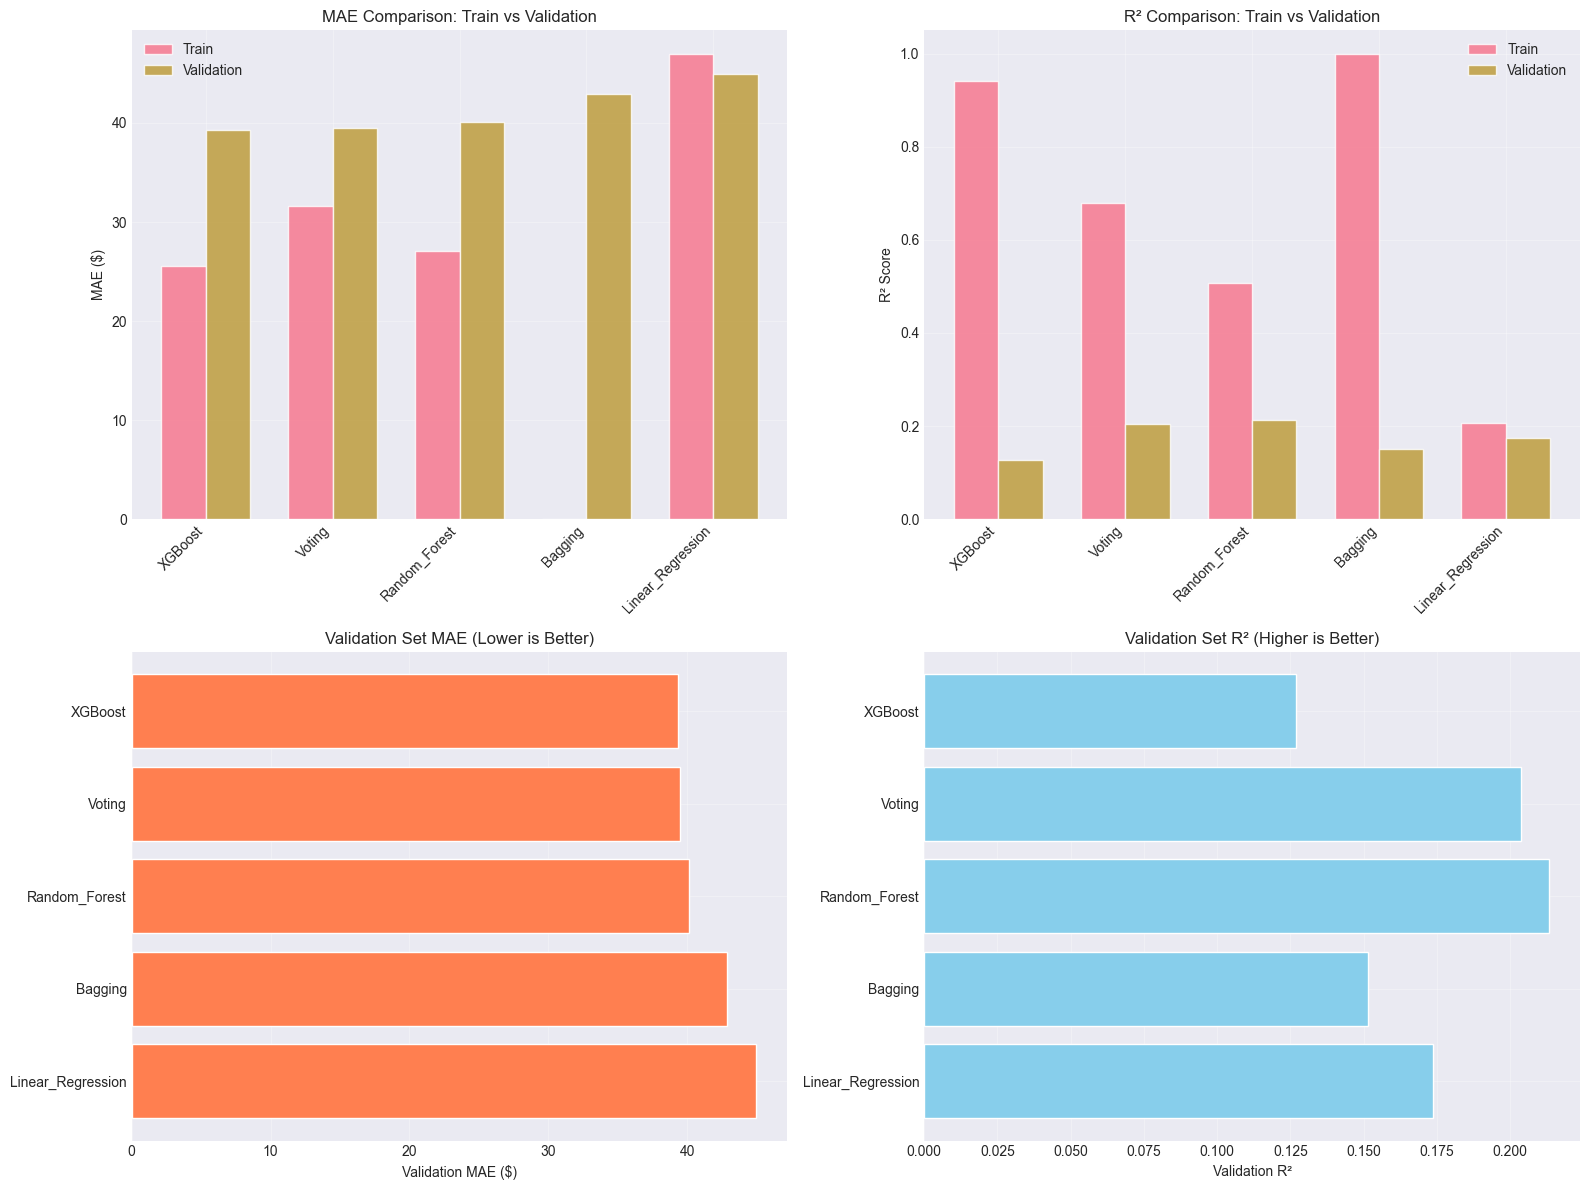

✓ Saved: Emin_plots/03_model_comparison_validation.png


In [15]:
# VISUALIZE MODEL COMPARISON (VALIDATION PHASE)
print("\n📊 Plotting model comparison (validation phase)...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df.index
x = np.arange(len(models))
width = 0.35

# MAE comparison (Train vs Val)
axes[0, 0].bar(x - width/2, comparison_df['train_mae'], width, label='Train', alpha=0.8)
axes[0, 0].bar(x + width/2, comparison_df['val_mae'], width, label='Validation', alpha=0.8)
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].set_title('MAE Comparison: Train vs Validation')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# R² comparison (Train vs Val)
axes[0, 1].bar(x - width/2, comparison_df['train_r2'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, comparison_df['val_r2'], width, label='Validation', alpha=0.8)
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Comparison: Train vs Validation')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation MAE only (sorted)
axes[1, 0].barh(models, comparison_df['val_mae'], color='coral')
axes[1, 0].set_xlabel('Validation MAE ($)')
axes[1, 0].set_title('Validation Set MAE (Lower is Better)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Validation R² only (sorted)
axes[1, 1].barh(models, comparison_df['val_r2'], color='skyblue')
axes[1, 1].set_xlabel('Validation R²')
axes[1, 1].set_title('Validation Set R² (Higher is Better)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Emin_plots/03_model_comparison_validation.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: Emin_plots/03_model_comparison_validation.png")



📊 Plotting best model predictions (validation phase)...


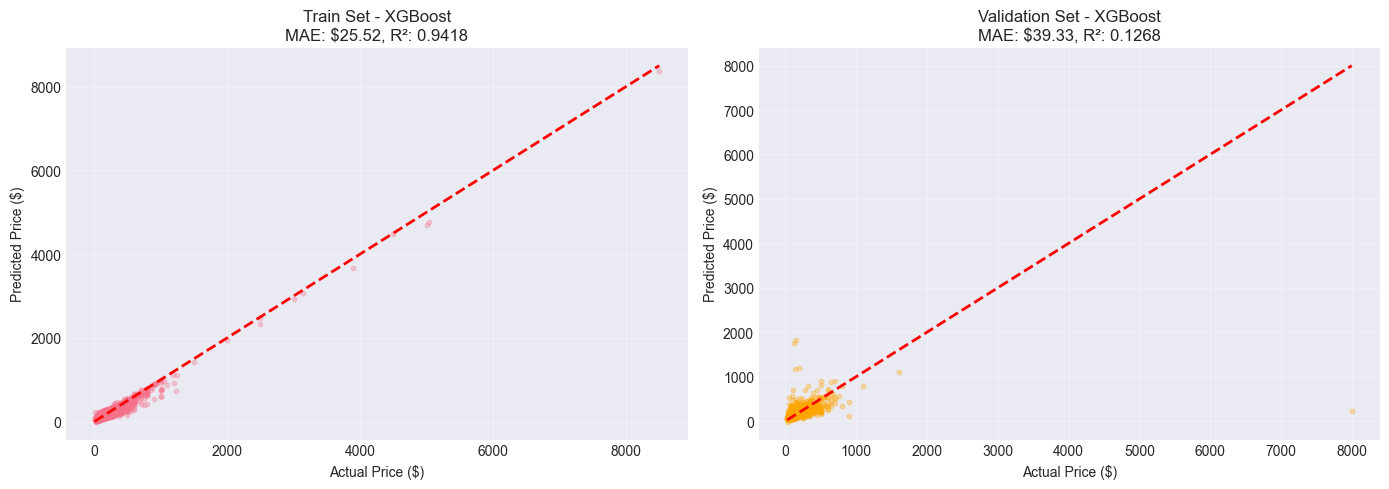

✓ Saved: Emin_plots/04_validation_phase_XGBoost_predictions.png


In [16]:
# VISUALIZE BEST MODEL PREDICTIONS (VALIDATION PHASE)
print("\n📊 Plotting best model predictions (validation phase)...")

# Get predictions for best model
if best_model_name == 'Linear_Regression':
    best_y_train_pred = y_train_pred_lr
    best_y_val_pred = y_val_pred_lr
elif best_model_name == 'Random_Forest':
    best_y_train_pred = y_train_pred_rf
    best_y_val_pred = y_val_pred_rf
elif best_model_name == 'Bagging':
    best_y_train_pred = y_train_pred_bag
    best_y_val_pred = y_val_pred_bag
elif best_model_name == 'Voting':
    best_y_train_pred = y_train_pred_vote
    best_y_val_pred = y_val_pred_vote
else:  # XGBoost
    best_y_train_pred = y_train_pred_xgb
    best_y_val_pred = y_val_pred_xgb

# Predictions vs Actual (Train and Val only)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].scatter(y_train, best_y_train_pred, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Train Set - {best_model_name}\nMAE: ${comparison_df.loc[best_model_name, "train_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "train_r2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, best_y_val_pred, alpha=0.3, s=10, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'Validation Set - {best_model_name}\nMAE: ${comparison_df.loc[best_model_name, "val_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "val_r2"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
safe_model_name = best_model_name.replace(' ', '_').replace('/', '_')
plt.savefig(f'Emin_plots/04_validation_phase_{safe_model_name}_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: Emin_plots/04_validation_phase_{safe_model_name}_predictions.png")



📊 Plotting residuals (validation phase)...


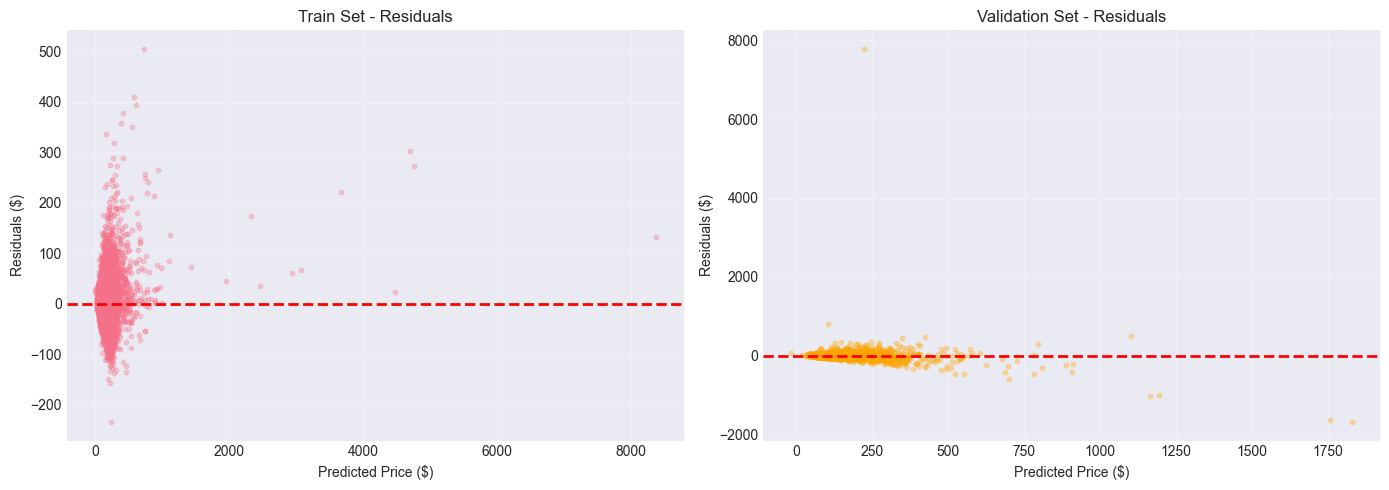

✓ Saved: Emin_plots/05_validation_phase_XGBoost_residuals.png


In [17]:
# VISUALIZE RESIDUALS (VALIDATION PHASE)
print("\n📊 Plotting residuals (validation phase)...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_residuals = y_train - best_y_train_pred
val_residuals = y_val - best_y_val_pred

# Train residuals
axes[0].scatter(best_y_train_pred, train_residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title(f'Train Set - Residuals')
axes[0].grid(True, alpha=0.3)

# Validation residuals
axes[1].scatter(best_y_val_pred, val_residuals, alpha=0.3, s=10, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'Validation Set - Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'Emin_plots/05_validation_phase_{safe_model_name}_residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: Emin_plots/05_validation_phase_{safe_model_name}_residuals.png")


In [18]:
#============================================================================
# STEP 9: RETRAIN BEST MODEL ON TRAIN+VAL FOR FINAL DEPLOYMENT
#============================================================================
print("\n" + "="*80)
print("STEP 9: RETRAINING BEST MODEL ON TRAIN+VAL")
print("="*80)

# Combine train and val data
X_trainval = np.vstack([X_train_eng, X_val_eng])
y_trainval = np.concatenate([y_train, y_val])

print(f"\n✓ Combined Train+Val dataset: {X_trainval.shape}")
print(f"  Train shape: {X_train_eng.shape}")
print(f"  Val shape:   {X_val_eng.shape}")

# Retrain the best model on train+val
print(f"\n🔄 Retraining {best_model_name} on Train+Val...")

if best_model_name == 'Linear_Regression':
    final_model = Ridge(alpha=ridge_grid.best_params_['alpha'], random_state=42)
    final_model.fit(X_trainval, y_trainval)

elif best_model_name == 'Random_Forest':
    final_model = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
    final_model.fit(X_trainval, y_trainval)

elif best_model_name == 'Bagging':
    final_model = BaggingRegressor(**bagging_random.best_params_, random_state=42, n_jobs=-1)
    final_model.fit(X_trainval, y_trainval)

elif best_model_name == 'Voting':
    # Retrain base models on train+val for voting
    final_ridge = Ridge(alpha=ridge_grid.best_params_['alpha'], random_state=42)
    final_ridge.fit(X_trainval, y_trainval)

    final_rf = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
    final_rf.fit(X_trainval, y_trainval)

    final_xgb_params = xgb_random.best_params_.copy()
    if use_gpu:
        final_xgb_params.update({'tree_method': 'hist', 'device': 'cuda', 'n_jobs': 1})
    else:
        final_xgb_params.update({'tree_method': 'hist', 'n_jobs': -1})
    final_xgb = XGBRegressor(**final_xgb_params, random_state=42)
    final_xgb.fit(X_trainval, y_trainval)

    final_model = VotingRegressor(
        estimators=[
            ('ridge', final_ridge),
            ('rf', final_rf),
            ('xgb', final_xgb)
        ],
        n_jobs=-1
    )
    final_model.fit(X_trainval, y_trainval)

else:  # XGBoost
    final_xgb_params = xgb_random.best_params_.copy()
    if use_gpu:
        final_xgb_params.update({'tree_method': 'hist', 'device': 'cuda', 'n_jobs': 1})
    else:
        final_xgb_params.update({'tree_method': 'hist', 'n_jobs': -1})
    final_model = XGBRegressor(**final_xgb_params, random_state=42)
    final_model.fit(X_trainval, y_trainval)

print("✓ Retraining complete!")

# Save the FINAL model
final_model_filename = f'Emin_models/FINAL_{best_model_name.lower().replace(" ", "_")}_model.pkl'
with open(final_model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"\n✓ Final model saved: {final_model_filename}")



STEP 9: RETRAINING BEST MODEL ON TRAIN+VAL

✓ Combined Train+Val dataset: (16022, 98)
  Train shape: (12016, 98)
  Val shape:   (4006, 98)

🔄 Retraining XGBoost on Train+Val...
✓ Retraining complete!

✓ Final model saved: Emin_models/FINAL_xgboost_model.pkl


In [19]:
#============================================================================
# STEP 10: EVALUATE FINAL MODEL ON TEST SET (UNSEEN DATA)
#============================================================================
print("\n" + "="*80)
print("STEP 10: FINAL EVALUATION ON TEST SET")
print("="*80)

# Predict on test set
y_test_pred_final = final_model.predict(X_test_eng)

# Calculate metrics
final_test_results = {
    'mae': mean_absolute_error(y_test, y_test_pred_final),
    'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_final)),
    'r2': r2_score(y_test, y_test_pred_final),
    'mape': mean_absolute_percentage_error(y_test, y_test_pred_final) * 100
}

print("\n" + "="*80)
print("🏆 FINAL TEST SET RESULTS (Unseen Data)")
print("="*80)
print(f"Model: {best_model_name} (Trained on Train+Val)")
print(f"Test MAE:  ${final_test_results['mae']:.2f}")
print(f"Test RMSE: ${final_test_results['rmse']:.2f}")
print(f"Test R²:   {final_test_results['r2']:.4f}")
print(f"Test MAPE: {final_test_results['mape']:.2f}%")

# Save final test results
final_results_df = pd.DataFrame([{
    'model': best_model_name,
    'training_data': 'Train+Val',
    'test_mae': final_test_results['mae'],
    'test_rmse': final_test_results['rmse'],
    'test_r2': final_test_results['r2'],
    'test_mape': final_test_results['mape']
}])
final_results_df.to_csv('Emin_models/FINAL_test_results.csv', index=False)
print("\n✓ Saved: Emin_models/FINAL_test_results.csv")



STEP 10: FINAL EVALUATION ON TEST SET

🏆 FINAL TEST SET RESULTS (Unseen Data)
Model: XGBoost (Trained on Train+Val)
Test MAE:  $38.96
Test RMSE: $82.25
Test R²:   0.3026
Test MAPE: 28.41%

✓ Saved: Emin_models/FINAL_test_results.csv



📊 Plotting final test set performance...


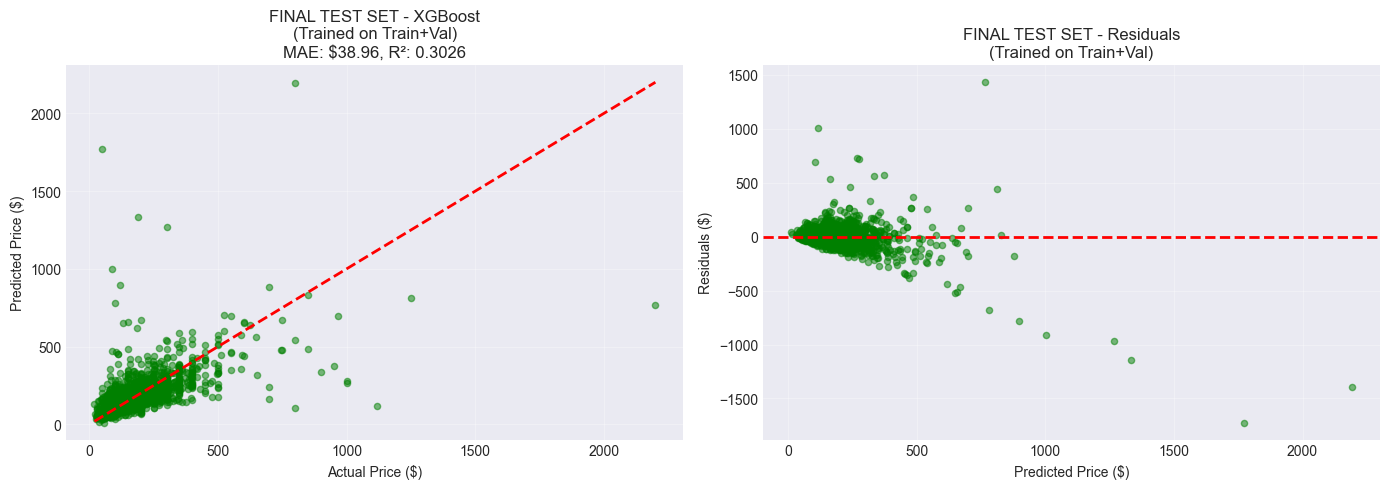

✓ Saved: Emin_plots/06_FINAL_test_performance_XGBoost.png


In [20]:
# VISUALIZE FINAL MODEL TEST PERFORMANCE
print("\n📊 Plotting final test set performance...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs Actual
axes[0].scatter(y_test, y_test_pred_final, alpha=0.5, s=20, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'FINAL TEST SET - {best_model_name}\n(Trained on Train+Val)\nMAE: ${final_test_results["mae"]:.2f}, R²: {final_test_results["r2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
test_residuals = y_test - y_test_pred_final
axes[1].scatter(y_test_pred_final, test_residuals, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'FINAL TEST SET - Residuals\n(Trained on Train+Val)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'Emin_plots/06_FINAL_test_performance_{safe_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: Emin_plots/06_FINAL_test_performance_{safe_model_name}.png")



COMPARISON: Validation vs Final Test Performance

                                     Stage    Dataset       MAE       RMSE       R²
Validation Phase\n(Trained on Train only) Validation 39.327414 143.487437 0.126802
 Final Test Phase\n(Trained on Train+Val)       Test 38.963345  82.252332 0.302578


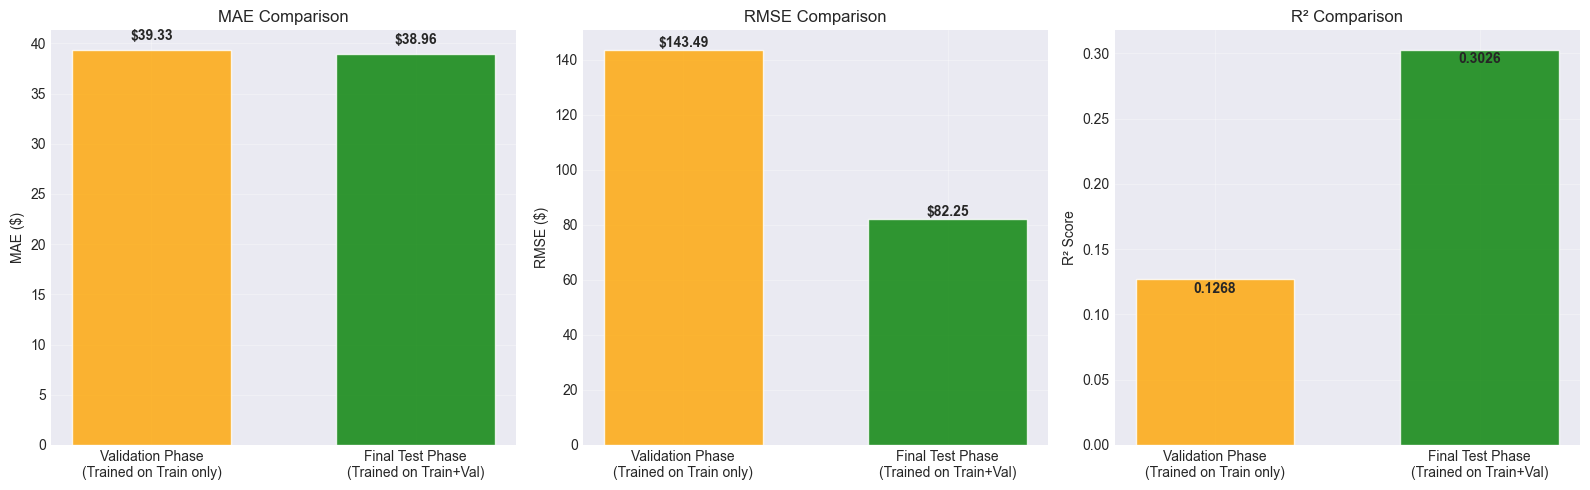


✓ Saved: Emin_plots/07_validation_vs_final_comparison.png


In [21]:
# COMPARISON: Before vs After Retraining
print("\n" + "="*80)
print("COMPARISON: Validation vs Final Test Performance")
print("="*80)

comparison_data = {
    'Stage': ['Validation Phase\n(Trained on Train only)', 'Final Test Phase\n(Trained on Train+Val)'],
    'Dataset': ['Validation', 'Test'],
    'MAE': [comparison_df.loc[best_model_name, 'val_mae'], final_test_results['mae']],
    'RMSE': [comparison_df.loc[best_model_name, 'val_rmse'], final_test_results['rmse']],
    'R²': [comparison_df.loc[best_model_name, 'val_r2'], final_test_results['r2']]
}

comparison_final_df = pd.DataFrame(comparison_data)
print("\n", comparison_final_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

stages = comparison_data['Stage']
x = np.arange(len(stages))
width = 0.6

# MAE
axes[0].bar(x, comparison_data['MAE'], width, color=['orange', 'green'], alpha=0.8)
axes[0].set_ylabel('MAE ($)')
axes[0].set_title('MAE Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(stages)
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(comparison_data['MAE']):
    axes[0].text(i, v + 1, f'${v:.2f}', ha='center', fontweight='bold')

# RMSE
axes[1].bar(x, comparison_data['RMSE'], width, color=['orange', 'green'], alpha=0.8)
axes[1].set_ylabel('RMSE ($)')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(stages)
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(comparison_data['RMSE']):
    axes[1].text(i, v + 1, f'${v:.2f}', ha='center', fontweight='bold')

# R²
axes[2].bar(x, comparison_data['R²'], width, color=['orange', 'green'], alpha=0.8)
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(stages)
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(comparison_data['R²']):
    axes[2].text(i, v - 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('Emin_plots/07_validation_vs_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: Emin_plots/07_validation_vs_final_comparison.png")


In [22]:
print("\n" + "="*80)
print("✅ TRAINING PIPELINE COMPLETE!")
print("="*80)
print("\n📋 WORKFLOW SUMMARY:")
print("  1. Loaded preprocessed data (Train/Val/Test)")
print("  2. Applied advanced feature engineering")
print("  3. Trained 5 models with hyperparameter tuning (CV on Train)")
print("  4. Selected best model based on Validation performance")
print(f"  5. Retrained {best_model_name} on Train+Val combined")
print("  6. Evaluated final model on Test set (unseen data)")
print("\n📁 SAVED FILES:")
print("  Models:")
print(f"    - {final_model_filename}")
print("    - Emin_models/FINAL_test_results.csv")
print("    - Emin_models/model_comparison_validation.csv")
print("\n  Visualizations:")
print("    - Emin_plots/01_target_distribution.png")
print("    - Emin_plots/02_feature_importance.png")
print("    - Emin_plots/03_model_comparison_validation.png")
print(f"    - Emin_plots/04_validation_phase_{safe_model_name}_predictions.png")
print(f"    - Emin_plots/05_validation_phase_{safe_model_name}_residuals.png")
print(f"    - Emin_plots/06_FINAL_test_performance_{safe_model_name}.png")
print("    - Emin_plots/07_validation_vs_final_comparison.png")
print("\n" + "="*80)
print("🎯 BEST MODEL SELECTED:", best_model_name)
print(f"📊 FINAL TEST MAE: ${final_test_results['mae']:.2f}")
print(f"📊 FINAL TEST R²: {final_test_results['r2']:.4f}")
print("="*80)




✅ TRAINING PIPELINE COMPLETE!

📋 WORKFLOW SUMMARY:
  1. Loaded preprocessed data (Train/Val/Test)
  2. Applied advanced feature engineering
  3. Trained 5 models with hyperparameter tuning (CV on Train)
  4. Selected best model based on Validation performance
  5. Retrained XGBoost on Train+Val combined
  6. Evaluated final model on Test set (unseen data)

📁 SAVED FILES:
  Models:
    - Emin_models/FINAL_xgboost_model.pkl
    - Emin_models/FINAL_test_results.csv
    - Emin_models/model_comparison_validation.csv

  Visualizations:
    - Emin_plots/01_target_distribution.png
    - Emin_plots/02_feature_importance.png
    - Emin_plots/03_model_comparison_validation.png
    - Emin_plots/04_validation_phase_XGBoost_predictions.png
    - Emin_plots/05_validation_phase_XGBoost_residuals.png
    - Emin_plots/06_FINAL_test_performance_XGBoost.png
    - Emin_plots/07_validation_vs_final_comparison.png

🎯 BEST MODEL SELECTED: XGBoost
📊 FINAL TEST MAE: $38.96
📊 FINAL TEST R²: 0.3026
